In [3]:
import numpy as np
import sys
import osqppurepy
from keras.preprocessing.image import img_to_array
from keras.applications.resnet50 import preprocess_input
from keras.applications.imagenet_utils import decode_predictions
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib.pyplot import imread, imshow, subplots, show
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,GlobalAveragePooling2D,Concatenate, ReLU, LeakyReLU,Reshape, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import metrics
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import glorot_uniform
from tqdm import tqdm
import tensorflow as tf
import imgaug as ia
from imgaug import augmenters as iaa
from PIL import Image
K.set_image_data_format('channels_last')
K.set_learning_phase(1)
#Redimmentionner les images
import cv2
import pickle
from os import listdir
import os

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
path_image = "/content/drive/My Drive/Potato"
path_dest = "/content/drive/My Drive/dataset"

In [ ]:
import os
import random
from shutil import copyfile

def img_train_test_split(img_source_dir, train_size):
    if not (isinstance(img_source_dir, str)):
        raise AttributeError('img_source_dir must be a string')

    if not os.path.exists(img_source_dir):
        raise OSError('img_source_dir does not exist')

    if not (isinstance(train_size, float)):
        raise AttributeError('train_size must be a float')

    # Set up empty folder structure if not exists

    if not os.path.exists('training'):
        os.makedirs('training')
    if not os.path.exists('test'):
        os.makedirs('test')

    # Get the subdirectories in the main image folder
    subdirs = [subdir for subdir in os.listdir(img_source_dir) if os.path.isdir(os.path.join(img_source_dir, subdir))]

    for subdir in subdirs:
        print(subdir)
        subdir_fullpath = os.path.join(img_source_dir, subdir)
        if len(os.listdir(subdir_fullpath)) == 0:
            print(subdir_fullpath + ' is empty')
            break

        train_subdir = os.path.join('/training', subdir)
        train_subdir = path_dest+train_subdir
        validation_subdir = os.path.join('/test', subdir)
        validation_subdir = path_dest+validation_subdir

        # Create subdirectories in train and validation folders
        if not os.path.exists(train_subdir):
            os.makedirs(train_subdir)

        if not os.path.exists(validation_subdir):
            os.makedirs(validation_subdir)

        train_counter = 0
        validation_counter = 0

        extension = [".B ", ".JPG", ".png", '.jpg']
        # Randomly assign an image to train or validation folder
        for filename in os.listdir(subdir_fullpath):

            file = str(filename.split('.')[0]) + ".JPG"
            #print(file)
            #print((extension[0]))
            #print(filename.endswith(tuple(extension[0])))
            if filename.endswith(tuple(extension)):
                fileparts = filename.split('.')
                #print(fileparts)

                if random.uniform(0, 1) <= train_size:
                    if extension[0] in filename:
                       # print(fileparts)
                       # print(filename)
                        copyfile(os.path.join(subdir_fullpath, filename),
                            os.path.join(train_subdir, str(train_counter) + '.' + fileparts[2]))
                        train_counter += 1
                    else:
                          copyfile(os.path.join(subdir_fullpath, filename),
                             os.path.join(train_subdir, str(train_counter) + '.' + fileparts[1]))
                          train_counter += 1
                else:
                       if extension[0] in filename:
                          copyfile(os.path.join(subdir_fullpath, filename),
                              os.path.join(validation_subdir, str(validation_counter) + '.' + fileparts[2]))
                          validation_counter += 1
                       else:
                          copyfile(os.path.join(subdir_fullpath, filename),
                              os.path.join(validation_subdir, str(validation_counter) + '.' + fileparts[1]))
                          validation_counter += 1

        print('Copied ' + str(train_counter) + ' images to data/train/' + subdir)
        print('Copied ' + str(validation_counter) + ' images to data/validation/' + subdir)

In [ ]:
#img_train_test_split(path_image,0.7)

In [8]:
#Définition des répertoires d'entrainement et de test
train_dataset = "/content/drive/My Drive/dataset/training"
test_dataset = "/content/drive/My Drive/dataset/test"
train_dir = os.path.join(train_dataset)

In [11]:
#Convert images in array
def convert_image_to_array(image_dir):
  default_image_size = tuple((256, 256))
  try:
      image = cv2.imread(image_dir)
      if image is not None :
        image = cv2.resize(image, default_image_size)   
        return img_to_array(image)
      else :
          return np.array([])
  except Exception as e:
        print(f"Error : {e}")
        return None

In [12]:
def read_images (directory_root=test_dataset):
  # Store images and labels of differents images
  image_list, label_list = [], []
  root_dir = listdir(directory_root)
  for d in root_dir:
    for plant_folder in root_dir :
     plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
     #print(plant_disease_folder_list)
     for image in plant_disease_folder_list:
      image_directory = f"{directory_root}/{plant_folder}/{image}"
      if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
        #print(plant_folder)
        image_list.append(convert_image_to_array(image_directory))
        label_list.append(plant_folder)
    return image_list, label_list

In [13]:
image_list, label_list = read_images ()

In [15]:
np.save('/content/drive/My Drive/dataset/images_test.npy', image_list)

In [16]:
np.save('/content/drive/My Drive/dataset/labels_test.npy', label_list)

In [5]:
#Chargement les images a partir du drive
images =np.load('/content/drive/My Drive/dataset/images.npy')
images_test =np.load('/content/drive/My Drive/dataset/images_test.npy')

In [15]:
print(len(images_test))

644


In [16]:
print(len(images))

1527


In [6]:
#Chargement les labels a partir du drive
labels=np.load('/content/drive/My Drive/dataset/labels.npy')
labels_test=np.load('/content/drive/My Drive/dataset/labels_test.npy')

In [ ]:
labels_test

In [23]:
labels

array(['Potato___healthy', 'Potato___healthy', 'Potato___healthy', ...,
       'Potato___Early_blight', 'Potato___Early_blight',
       'Potato___Early_blight'], dtype='<U21')

In [25]:
labels=set(labels)
labels

{'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy'}

In [26]:
images[0].shape

(256, 256, 3)

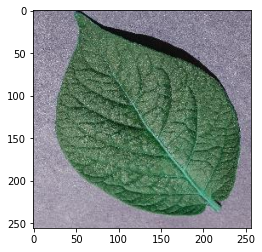

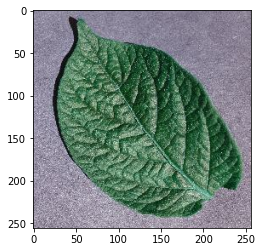

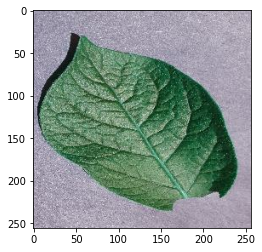

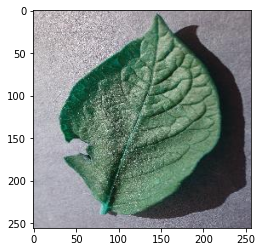

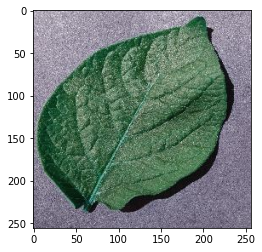

In [27]:
for j in range(5):
  plt.imshow(images[j].astype('uint8'))
  plt.show()

In [9]:
# Parametres de l'image
EPOCHS = 20
INIT_LR = 1e-3
batch_size = 17

In [10]:
# Generates batches of image data with data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=360, # Degree range for random rotations
                                   width_shift_range=0.2, # Range for random horizontal shifts
                                   height_shift_range=0.2, # Range for random vertical shifts
                                   zoom_range=0.2, # Range for random zoom
                                   horizontal_flip=True, # Randomly flip inputs horizontally
                                   vertical_flip=True,
                                   shear_range=0.2,
                                   fill_mode="nearest"
                                   )
                                   
valid_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=360, # Degree range for random rotations
                                   width_shift_range=0.2, # Range for random horizontal shifts
                                   height_shift_range=0.2, # Range for random vertical shifts
                                   zoom_range=0.2, # Range for random zoom
                                   horizontal_flip=True, # Randomly flip inputs horizontally
                                   vertical_flip=True,
                                   shear_range=0.2,
                                   fill_mode="nearest"
                                   )

training_iterator = train_datagen.flow_from_directory(train_dataset,
                                                 target_size=(256, 256),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')

test_iterator = valid_datagen.flow_from_directory(test_dataset,
                                            target_size=(256, 256),
                                            batch_size=batch_size,
                                            class_mode='categorical')

Found 1527 images belonging to 3 classes.
Found 644 images belonging to 3 classes.


In [30]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

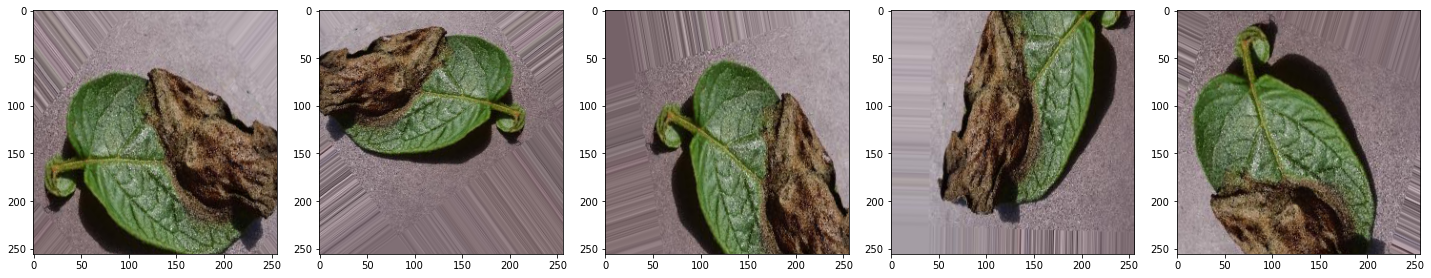

In [ ]:
augmented_images = [training_iterator[1][0][0] for i in range(5)]
plotImages(augmented_images)

In [31]:
#Display of the different classes of the dataset with indices
class_dict = training_iterator.class_indices
print(class_dict)

{'Potato___Early_blight': 0, 'Potato___Late_blight': 1, 'Potato___healthy': 2}


In [33]:
label_list =list(class_dict.keys())
print(label_list)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [55]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
n_classes = len(label_binarizer.classes_)
print(n_classes)

3


In [37]:
train_num_samples = training_iterator.samples
valid_num_samples = test_iterator.samples

In [ ]:
#Formation of the model

In [38]:
def identity_block(X, f, filters, stage, block):
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    F1, F2, F3 = filters
    
    X_shortcut = X
        
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
        
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Add shortcut value to main path
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
        
    return X

In [39]:
def convolutional_block(X, f, filters, stage, block, s = 2):
        
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
    X_shortcut = X
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
   
    return X

In [40]:
def ResNet50(input_shape = (256, 256, 3), classes = n_classes):
    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    X = AveragePooling2D(pool_size=(2, 2),name='avg_pool')(X)
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    model = Model(inputs = X_input, outputs = X, name='ResNet50')
    tf.keras.utils.plot_model( model, to_file='ResNet50.png', show_shapes=False, show_layer_names=True)
    return model

In [41]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

In [42]:
model = ResNet50(input_shape = (256, 256, 3), classes = n_classes)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [44]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopper = EarlyStopping(min_delta=0.001, patience=10)
filepath="/content/drive/My Drive/TPE_GIT/ModelWithDataAug/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [45]:
history = model.fit_generator(training_iterator,
                              steps_per_epoch=int(len(training_iterator)/batch_size),
                              epochs=EPOCHS,
                              validation_data=test_iterator,
                              validation_steps=20,
                              callbacks=[checkpoint])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
5/5 [==============================] - ETA: 0s - loss: 6.8781 - accuracy: 0.6118 
Epoch 00001: val_accuracy improved from -inf to 0.47941, saving model to /content/drive/My Drive/TPE_GIT/ModelWithDataAug/weights-improvement-01-0.48.hdf5
5/5 [==============================] - 158s 32s/step - loss: 6.8781 - accuracy: 0.6118 - val_loss: 996.1415 - val_accuracy: 0.4794
Epoch 2/20
5/5 [==============================] - ETA: 0s - loss: 2.2963 - accuracy: 0.5765 
Epoch 00002: val_accuracy improved from 0.47941 to 0.56176, saving model to /content/drive/My Drive/TPE_GIT/ModelWithDataAug/weights-improvement-02-0.56.hdf5
5/5 [==============================] - 153s 31s/step - loss: 2.2963 - accuracy: 0.5765 - val_loss: 11406.8018 - val_accuracy: 0.5618
Epoch 3/20
5/5 [==============================] - ETA: 0s - loss: 0.8688 - accuracy: 0.6471 
Epoch 00003: val_accuracy improved from 0.56176 to 0.79706, saving m

In [11]:
Model = tf.keras.models.load_model('/content/drive/My Drive/TPE_GIT/ModelWithDataAug/weights-improvement-03-0.80.hdf5')

In [23]:
# Evaluate the model
_, acc = Model.evaluate_generator(test_iterator, steps=len(test_iterator), verbose=1)
print('> %.3f' % (acc * 100.0))

Instructions for updating:
Please use Model.evaluate, which supports generators.
38/38 [==============================] - 161s 4s/step - loss: 437.0605 - accuracy: 0.7873
> 78.727


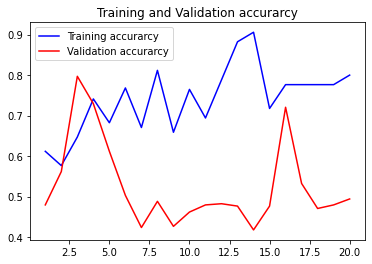

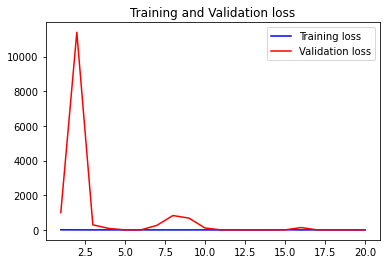

In [67]:
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
#Train and validation accuracy
plt.plot(epochs, accuracy, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
predictions = Model.predict_generator(test_iterator, int(len(test_iterator)))
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_iterator.classes
class_labels = list(test_iterator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
accuracy = accuracy_score(true_classes, predicted_classes)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
print(report)

                       precision    recall  f1-score   support

Potato___Early_blight       0.47      0.46      0.46       295
 Potato___Late_blight       0.47      0.55      0.51       302
     Potato___healthy       0.00      0.00      0.00        47

             accuracy                           0.47       644
            macro avg       0.31      0.34      0.32       644
         weighted avg       0.44      0.47      0.45       644



In [15]:
print(accuracy)

0.4704968944099379


In [18]:
import seaborn as sns
import pandas as pd

# Fonction d'aide pour afficher la matrice de confusion
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

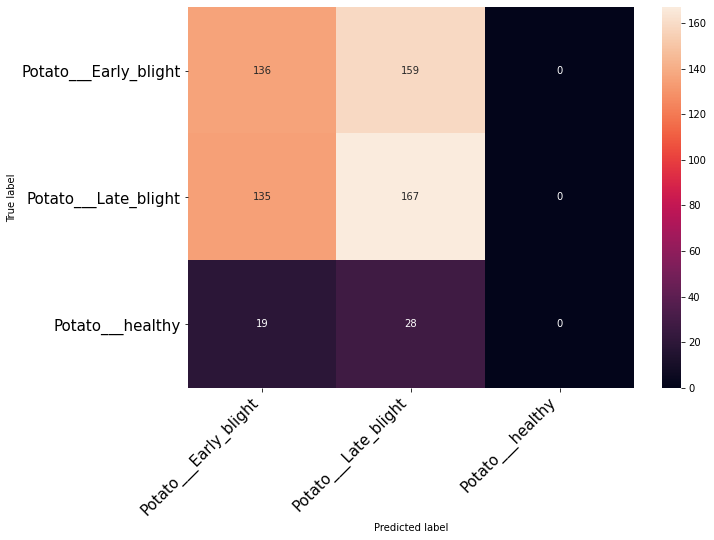

In [19]:
CM = confusion_matrix(true_classes, predicted_classes )
fig = print_confusion_matrix(CM, class_labels, figsize = (10,7), fontsize=15)

fig.show()